https://github.com/sunilgoda/nn_text_classification/blob/master/notebooks/NeuralNetworks_TextClassification.ipynb

In [5]:
!ls

sample_data


In [103]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as k

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten,Dropout,BatchNormalization,Lambda
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPool1D,Embedding
from keras.layers import LSTM,GRU,RNN
from keras.models import Sequential
from keras.optimizers import Adam, Adagrad,Adadelta,Nadam
from keras import callbacks
from keras import regularizers
from keras.utils import plot_model
from keras.models import load_model
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt 
%matplotlib inline

In [74]:
from google.colab import files
test = files.upload()

Saving facebook_health_cases (original v4.1).csv to facebook_health_cases (original v4.1).csv


In [8]:
test = files.upload()

Saving facebook_health_cases (val v4).csv to facebook_health_cases (val v4).csv


In [9]:
test = files.upload()

Saving facebook_health_cases (test v4).csv to facebook_health_cases (test v4).csv


In [10]:
!ls

'facebook_health_cases (augmented v4.1).csv'
'facebook_health_cases (test v4).csv'
'facebook_health_cases (val v4).csv'
 sample_data


In [76]:
texts = pd.read_csv('facebook_health_cases (original v4.1).csv')
df_train = pd.DataFrame(texts)
df_train.head()

,date,text,cleaned,sentiment
0,20210420,LOL....u mean the country is still in first wa...,lol u mean country still first wave becoz prev...,negative
1,20210417,The nation didn't drink enough warm water...mu...,nationdidntdrink enough warm water must make m...,negative
2,20210419,Important news for Malaysia.,important news malaysia,neutral
3,20210419,so .... another election the case will go up a...,another election case go blame citizen not fol...,negative
4,20210419,Wat abt the earlier times wen we had less case...,wat abt earlier times wen less cases colleague...,negative


In [77]:
df_train = df_train.drop_duplicates(subset=['cleaned'])
df_train.shape

(5238, 4)

In [78]:
texts = pd.read_csv('facebook_health_cases (val v4).csv')
df_val = pd.DataFrame(texts)
df_val.head()

,date,text,cleaned,sentiment
0,20210222,peliknye perak trun mendadak..dr 1k++ trun ke ...,peliknya perak turun mendadak ribu turun,negative
1,20210212,dalam majlis yg dihadiri menteri ramai je yang...,majlis dihadiri menteri ramai tidak pakai mask...,negative
2,20210222,akhirnya selangor merampas kembali ranking per...,selangor merampas ranking studio,neutral
3,20210107,emmm 3k...tp masih ada lagi sesetengah rakyat ...,em ribu sesetengah rakyat malaysia enjoy bercu...,negative
4,20210303,Kes baru dh kluster tmpt keje jer byk mcm kila...,kes kluster kerja banyak kilang pembinaan dibe...,negative


In [79]:
texts = pd.read_csv('facebook_health_cases (test v4).csv')
df_test = pd.DataFrame(texts)
df_test.head()

,date,text,cleaned,sentiment
0,20210306,Alhamdulillah hari demi hari covid semakin ber...,covid berkurangan semoga sambut ramadhan tanpa...,positive
1,20210106,masih terkawal lagi sebab belum sampai 3000 💩💩💩,terkawal belum,negative
2,20210205,tutup je utk 7-10hari(lockdown cam pkp 1.0...m...,tutup lockdown pkp mac jangan penduduk menangi...,negative
3,20210123,seronok pkp kalini... meriah jer atas jalan ra...,seronok pkp kali meriah jalan raya sambut merdeka,negative
4,20210204,selangor masih mengungguli carta.. tahniah unt...,selangor mengungguli carta tahniah red giant,negative


In [80]:
train_frames = [df_train, df_test, df_val]
df_all = pd.concat(train_frames)

In [81]:
df_all

,date,text,cleaned,sentiment
0,20210420,LOL....u mean the country is still in first wa...,lol u mean country still first wave becoz prev...,negative
1,20210417,The nation didn't drink enough warm water...mu...,nationdidntdrink enough warm water must make m...,negative
2,20210419,Important news for Malaysia.,important news malaysia,neutral
3,20210419,so .... another election the case will go up a...,another election case go blame citizen not fol...,negative
4,20210419,Wat abt the earlier times wen we had less case...,wat abt earlier times wen less cases colleague...,negative
...,...,...,...,...
727,20210418,Bacause our leaders busy die2 want election ev...,bacause leaders busy die want election even co...,negative
728,20210420,No 4th wave... But got 3rd wave 2.0,nofourthwave gotthirdwave,negative
729,20210416,Now many cases happened in schools.,many cases happened schools,negative
730,20210416,I hope our YB Ismail Sabri cannot b too compla...,hope yb ismail sabri cannot b complacement com...,negative


In [82]:
print("Max length: %s" %df_all.cleaned.str.len().max())
print("Mean length: %s" %df_all.cleaned.str.len().mean())
print("Min length: %s" %df_all.cleaned.str.len().min())

Max length: 1548
Mean length: 142.3143922445936
Min length: 3


In [83]:
MAX_SEQ_LEN = 1300
VOCAB_SIZE = 100000

- fits_on_texts:

Updates internal vocabulary based on a list of texts.

In the case where texts contains lists, we assume each entry of the lists to be a token.

Required before using texts_to_sequences or texts_to_matrix.


- texts_to_sequences:

Transforms each text in texts to a sequence of integers.

Only top num_words-1 most frequent words will be taken into account. Only words known by the tokenizer will be taken into account.

In [84]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE)
tokenizer.fit_on_texts(df_all.cleaned)

train_sequences = tokenizer.texts_to_sequences(df_train.cleaned)
val_sequences = tokenizer.texts_to_sequences(df_val.cleaned)
test_sequences = tokenizer.texts_to_sequences(df_test.cleaned)

That + 1 is because of reserving padding (i.e. index zero).

In [85]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 12075 unique tokens.


In [86]:
train_data = pad_sequences(train_sequences, maxlen= MAX_SEQ_LEN)
val_data = pad_sequences(val_sequences, maxlen= MAX_SEQ_LEN)
test_data = pad_sequences(test_sequences, maxlen= MAX_SEQ_LEN)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(5238, 1300)
(732, 1300)
(735, 1300)


(row, max_seq_len) 

In [87]:
train_labels = df_train.sentiment

In [88]:
train_labels

0       negative
1       negative
2        neutral
3       negative
4       negative
          ...   
5233     neutral
5234    negative
5235    negative
5236    negative
5237    negative
Name: sentiment, Length: 5238, dtype: object

In [89]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)

print(label_encoder.classes_)

['negative' 'neutral' 'positive']


In [90]:
train_labels

array([0, 0, 1, ..., 0, 0, 0])

In [91]:
#convert to labels to one-hot-coded
train_tensor = to_categorical(np.array(train_labels))

print("Train tensor shape:",train_data.shape)
print("Train labels tensor shape:",train_tensor.shape)

Train tensor shape: (5238, 1300)
Train labels tensor shape: (5238, 3)


In [92]:
val_labels = df_val.sentiment

label_encoder = LabelEncoder()
label_encoder.fit(val_labels)
val_labels = label_encoder.transform(val_labels)

print(label_encoder.classes_)

val_tensor = to_categorical(np.array(val_labels))

print("Validation tensor shape:",val_data.shape)
print("validation labels tensor shape:",val_tensor.shape)

['negative' 'neutral' 'positive']
Validation tensor shape: (732, 1300)
validation labels tensor shape: (732, 3)


In [93]:
EMBEDDING_DIM = 100
INITIALIZER = 'he_uniform'
REGULARIZER = regularizers.l2(0.01)

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim= VOCAB_SIZE, 
                    output_dim= EMBEDDING_DIM ,
                    input_length= MAX_SEQ_LEN,
                    embeddings_regularizer = REGULARIZER
                   ))
cnn_model.add(Conv1D(filters= 64, kernel_size= 3,activation= 'relu',
                 kernel_initializer= INITIALIZER ,
                 #kernel_regularizer= REGULARIZER
                ))
cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',
                 kernel_initializer= INITIALIZER,
                 #kernel_regularizer= REGULARIZER
                 ))
cnn_model.add(GlobalMaxPool1D())
#cnn_model.add(MaxPool1D())
cnn_model.add(Dropout(0.2))
cnn_model.add(BatchNormalization())

#cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',padding = 'same'))
#cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',padding = 'same'))

cnn_model.add(Dense(128, activation= 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(3,activation= 'softmax'))

In [94]:
adam = Adam(lr=0.001)
#adagrad = Adagrad()
#adadelta = Adadelta()
#nadam = Nadam(lr=0.001)
cnn_model.compile(loss = 'categorical_crossentropy',
             optimizer = adam,
             metrics = ['accuracy']
             )

cnn_model.summary()
metric = "val_accuracy"

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1300, 100)         10000000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1298, 64)          19264     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1294, 64)          20544     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

### Define Callback

In [95]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor= metric, factor= 0.1,
                                       patience= 10, min_lr= 0.00001,
                                       verbose= 1)

early_stop = callbacks.EarlyStopping(monitor= metric, mode= 'auto',
                                     patience= 15,
                                    verbose= 1)
                                    #restore_best_weights= True)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
file_path = "cnn_weights.hdf5"
model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)

In [96]:
history = cnn_model.fit(train_data , train_tensor ,
         batch_size = 64, shuffle = True,
         epochs=1000,
         validation_data = (val_data, val_tensor),
         callbacks = [reduce_lr,early_stop,model_chkpt]
         )

Epoch 1/1000
82/82 [==============================] - 8s 87ms/step - loss: 36.4338 - accuracy: 0.4119 - val_loss: 2.0793 - val_accuracy: 0.5738
Epoch 2/1000
82/82 [==============================] - 7s 82ms/step - loss: 1.7964 - accuracy: 0.6732 - val_loss: 1.6728 - val_accuracy: 0.5738
Epoch 3/1000
82/82 [==============================] - 7s 83ms/step - loss: 1.2620 - accuracy: 0.7608 - val_loss: 1.5506 - val_accuracy: 0.5738
Epoch 4/1000
82/82 [==============================] - 7s 83ms/step - loss: 1.0003 - accuracy: 0.8198 - val_loss: 1.4883 - val_accuracy: 0.5874
Epoch 5/1000
82/82 [==============================] - 7s 84ms/step - loss: 0.8388 - accuracy: 0.8790 - val_loss: 1.4838 - val_accuracy: 0.6038
Epoch 6/1000
82/82 [==============================] - 7s 84ms/step - loss: 0.8014 - accuracy: 0.9021 - val_loss: 1.5328 - val_accuracy: 0.6339
Epoch 7/1000
82/82 [==============================] - 7s 84ms/step - loss: 0.7849 - accuracy: 0.9136 - val_loss: 1.4277 - val_accuracy: 0.685

In [97]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

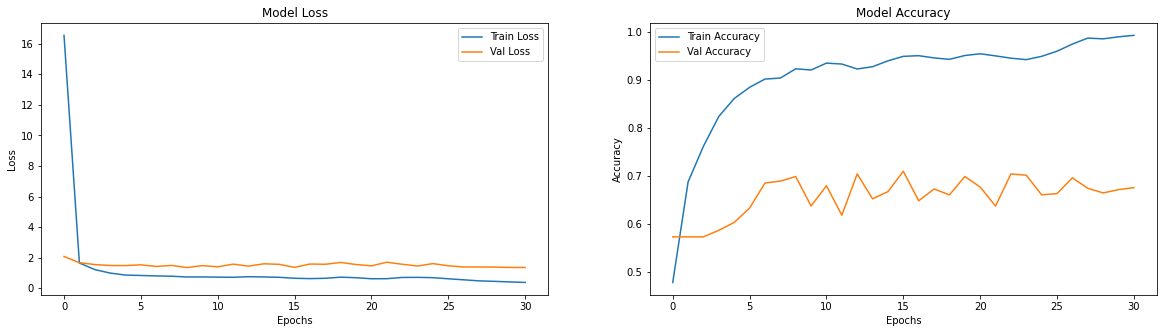

In [98]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,2,1)
ax.set_title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss , label ="Train Loss")
plt.plot(val_loss, label ="Val Loss")
plt.legend()

ax = plt.subplot(1,2,2)
ax.set_title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(val_acc, label = "Val Accuracy")
plt.legend()
plt.show();

In [99]:
evaluation = cnn_model.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

164/164 [==============================] - 4s 26ms/step - loss: 0.3453 - accuracy: 0.9996
Train Loss: 0.345319 Train Accuracy: 0.999618


In [100]:
test_labels = df_test.sentiment
label_encoder = LabelEncoder()
label_encoder.fit(df_test.sentiment)
test_labels = label_encoder.transform(test_labels)

test_tensor = to_categorical(np.array(test_labels))

loss, accuracy = cnn_model.evaluate(test_data, test_tensor)
print("Testing Accuracy:  {:.4f}".format(accuracy))

23/23 [==============================] - 1s 25ms/step - loss: 1.2360 - accuracy: 0.7102
Testing Accuracy:  0.7102


In [101]:
best_weights_cnn = load_model(file_path)
loss, accuracy = best_weights_cnn.evaluate(test_data, test_tensor)
print("Testing Accuracy:  {:.4f}".format(accuracy))

23/23 [==============================] - 1s 24ms/step - loss: 1.2525 - accuracy: 0.7401
Testing Accuracy:  0.7401


In [102]:
# with best weight
evaluation = best_weights_cnn.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

164/164 [==============================] - 4s 24ms/step - loss: 0.5530 - accuracy: 0.9842
Train Loss: 0.553044 Train Accuracy: 0.984154


In [104]:
y_pre=best_weights_cnn.predict(test_data)

In [112]:
scores = []
for i in y_pre:
  scores.append(np.where(i == np.amax(i))[0][0])

In [113]:
print(classification_report(y_true = test_labels, y_pred = scores))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       452
           1       0.32      0.51      0.39        83
           2       0.81      0.65      0.72       200

    accuracy                           0.74       735
   macro avg       0.66      0.66      0.65       735
weighted avg       0.77      0.74      0.75       735



In [106]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [109]:
y_true = np.array(test_labels)

In [120]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, scores)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, scores, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, scores, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, scores, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.740136
Precision: 0.655473
Recall: 0.658748
F1 score: 0.646961


In [72]:
sub=pd.DataFrame({'check':df_test.cleaned.values.tolist(),'target':df_test.sentiment.values.tolist(),'predicted':scores})

In [73]:
sub.to_csv('cnn_check_test.csv',index=False)
files.download('cnn_check_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_pre=best_weights_cnn.predict(val_data)

scores = []
for i in y_pre:
  scores.append(np.where(i == np.amax(i))[0][0])

sub=pd.DataFrame({'check':df_val.check.values.tolist(),'target':df_val.sentiment.values.tolist(),'predicted':scores})
sub.to_csv('cnn_check_val.csv',index=False)
files.download('cnn_check_val.csv')

In [ ]:
files.download(file_path) #download model